In [40]:
import pandas as pd
import selfies as sf
from rdkit import Chem
from rdkit.Chem import AllChem
import re
import os

def selfies_to_smiles(selfies):
    """
    Converts a SELFIES string representation to a SMILES string representation.

    Parameters:
    -----------
    selfies : str
        The input SELFIES string to be converted.

    Returns:
    --------
    smiles : str
        The converted SMILES string.
    """
    smiles = sf.decoder(selfies)
    return smiles

def optimize_conformation(mol):
    """
    Optimize the conformation of a molecule using MMFF force field.

    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        The molecule to be optimized.

    Returns:
    --------
    mol : rdkit.Chem.rdchem.Mol
        The optimized molecule.
    """
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    return mol

def dock_molecule(mol, dock_pr):
    """
    Dock a molecule to a protein and calculate the binding affinity score.

    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        The molecule to be docked.

    dock_pr : dict
        A dictionary containing the docking parameters:
            - protein_path : str
                The path to the protein file (in PDB format).
            - x_center : float
                The x-coordinate of the docking center.
            - y_center : float
                The y-coordinate of the docking center.
            - z_center : float
                The z-coordinate of the docking center.
            - size : float
                The size of the docking box.
            - exhaust : int
                The exhaustiveness of the docking search.
            - program : str
                The name of the docking program to use.

    Returns:
    --------
    score : float
        The binding affinity score.
    """
    Chem.MolToMolFile(mol, f'molecule.mol')
    !obabel -imol molecule.mol -omol2 -O molecule.mol2
    os.remove(f'molecule.mol')
    protein = dock_pr['protein_path']
    x_center = dock_pr['x_center']
    y_center = dock_pr['y_center']
    z_center = dock_pr['z_center']
    size = dock_pr['size']
    exh = dock_pr['exhaust']
    program = dock_pr['program']

    !{program} -r {protein} -l molecule.mol2 --center_x {x_center} --center_y {y_center} --center_z {z_center} --size_x {size} --size_y {size} --size_z {size} --exhaustiveness {exh} --out molecule_docked.mol2

    output = !{program} -r d2_receptor.pdb -l molecule_docked.mol2 --score_only
    score = float(re.findall(r'Affinity:\s*(\-?[\d\.]+)', '\n'.join(output))[0])
    return score

class Docker:
    """
        A class to perform molecular docking on a set of molecules.

        Parameters:
        -----------
        dock_params : dict
            A dictionary containing the docking parameters.

        data_path : str
            The path to the data file (in CSV format) containing the molecules to be docked.

        column : str
            The name of the column in the data file that contains the SMILES strings.

        n_samples : int
            The number of samples to select from the data for docking.

        threshold : float
            The threshold value for filtering the data based on a specific column.

        Attributes:
        -----------
        data_path : str
            The path to the data file.

        column : str
            The name of the column in the data file.

        n_samples : int
            The number of samples to select.

        threshold : float
            The threshold value for filtering the data.

        data : pandas.DataFrame
            The loaded data from the CSV file.

        samples : pandas.DataFrame
            The selected samples from the data.

        dock_params : dict
            The docking parameters.

        Methods:
        --------
        perform_docking():
            Performs docking on the selected samples and stores the docking scores in the samples DataFrame.
    """
    def __init__(self, dock_params, data_path, column, n_samples, threshold):  # for d2
        self.data_path = data_path
        self.column = column
        self.n_samples = n_samples
        self.threshold = threshold
        self.data = pd.read_csv(data_path, sep=',')
        self.data = self.data[self.data.iloc[:, 1] < self.threshold]
        self.samples = self.data.sample(n=self.n_samples)
        self.dock_params = dock_params

    def perform_docking(self):
        docking_scores = []
        for i, row in self.samples.iterrows():
            smiles = row[self.column]
            mol = Chem.MolFromSmiles(smiles)
            optimize_conformation(mol)
            score = dock_molecule(mol, self.dock_params)
            docking_scores.append(score)
        self.samples["Scores"] = docking_scores

In [41]:
dock_params = {
    'protein_path': './d2_receptor.pdb',
    'x_center': 8,
    'y_center': 5,
    'z_center': -5,
    'size': 25,
    'exhaust': 8,
    'program': 'smina'
}

docker = Docker(dock_params, './d2_smiles.csv', 'SMILES', 1, 240.1) # test for d2
docker.perform_docking()

1 molecule converted


   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 1850992724

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


In [21]:
print(docker.samples)

docker.samples = docker.samples.sort_values(by="Scores")
docker.samples.to_csv(f"./d2_original_samples.csv", sep=',', index=False)

                                                  SMILES   "Ki"   Scores
11715  OC=O.OCCSSCCOc1ccc(cc1)C(=O)CCCN1CCC(O)(CC1)c1...   73.0 -9.81196


In [22]:
art = pd.read_csv('./d2_artificial_samples.csv', sep=',')
org = pd.read_csv('./d2_original_samples.csv', sep=',').iloc[:,[0,2]]

In [23]:
art['Data'] = 'Artificial'
org['Data'] = 'Original'

comb = pd.concat([art, org], axis=0)
comb = comb[comb['Scores']<10]

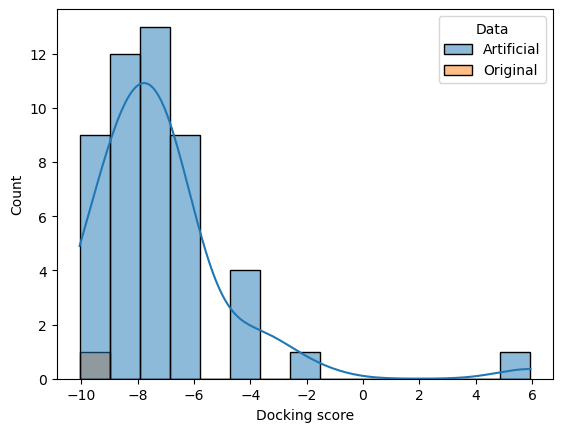

In [24]:
sns.histplot(data=comb, x='Scores', hue='Data', kde=True)
plt.xlabel('Docking score')
plt.ylabel('Count')

plt.savefig(f"./Docking_scores_comp.png", dpi=300, bbox_inches='tight')
plt.show()